# 12bis Associate Ca2+ signal with sleep stages from multiple subsessions

load packages

In [205]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [206]:
import quantities as pq
import numpy as np
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [207]:
folder_base = Path('//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/ThreeBlueCrossesOK')
session = 3
subsession = 2

folder_base2 = folder_base / f'session{session}/'
folder_Ephys = folder_base / f'session{session}/OpenEphys/'
folder_Minis = folder_base / f'session{session}/V4_Miniscope/session{session}{subsession}/minian/'

folder_mini = folder_base / f'session{session}/V4_Miniscope'

numbsubsession = sum(1 for p in folder_mini.iterdir() if p.is_dir())

filenameE = folder_Ephys / f'ScoredSleep.npy'
SleepScoredTS = np.load(filenameE)
filenameB = folder_base2 / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)

dict_minian = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base2 / f'V4_Miniscope/session{session}{x}/minian'
    dict_minian["ds_minian{0}".format(x)] = open_minian(folder_MinisSess)

for file_path in folder_base2.glob('**/timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])


try:
    TodropFile = folder_Minis / f'TodropFileAB.json'
    with open(TodropFile, 'r') as f:
        unit_to_drop = json.load(f)
        print('AB file')
except Exception:
    TodropFile = folder_Minis / f'TodropFile.json'
    with open(TodropFile, 'r') as f:
        print('Not an AB file')
        unit_to_drop = json.load(f)

#TodropFile = folder_Minis / f'TokeepFile.json'
#with open(TodropFile, 'r') as f:
#    unit_to_keep = json.load(f)

TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepL = [e for e in All_units if e not in unit_to_drop]
#UnitToKeepL = [e for e in All_units if e in unit_to_keep]
#unit_to_drop = [e for e in All_units if e not in unit_to_keep]
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(UnitToKeepL)
print(unit_to_drop)
print(All_units)


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

AB file
[3, 8, 9]
[10, 11, 13]
[3, 8, 9, 10, 11, 13]


Decide which session to analyse and assign the right files

In [208]:
# start time
StartTime1 = (list(stamps[0])[0])

# start time session 2
def Convert(string):
    li = list(string.split(", "))
    li2 = len(li)
    return li2
stri = stamps[0][3]

numbdropfr = Convert(stri)


from ast import literal_eval
list_droppedframes = literal_eval(stamps[0][3])


dict_StartTime = {}
dict_StartTime[1] = (list(stamps[0])[0])
dict_EndTime = {}
dict_RecDur = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base2 / f'V4_Miniscope/session{session}{x}/minian'
    minian_ds = open_minian(folder_MinisSess)
    C = minian_ds['S']
    dict_RecDur[x] = C.shape[1]
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(numbdropfr) if list_droppedframes[item] < dict_RecDur[x]))
    else:
        numbdropfr = 0
    dict_EndTime[x] = dict_StartTime[x] + (dict_RecDur[x] + numbdropfr)/stamps[0][2]
    if x < numbsubsession:
        dict_StartTime[x+1] = dict_EndTime[x]

print(dict_StartTime)
print(dict_EndTime)
print(dict_RecDur)

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

{1: 2.89656, 2: 1036.2298933333332}
{1: 1036.2298933333332, 2: 2063.5298933333333}
{1: 31000, 2: 30819}


0 on closest matching time point.


In [209]:
StartTime = dict_StartTime[subsession]
EndTime = dict_EndTime[subsession]
rec_dur = dict_RecDur[subsession]
minian_ds = dict_minian[f"ds_minian{subsession}"]

# update start time of sleep scored time serie
P = round(StartTime)
multiple5 = [*range(0, 10000, 5)]
for ind in multiple5:
    if StartTime==ind:
        P = ind
        Pupd = int(P/5)
    elif (StartTime>ind) and (StartTime<(ind+5)):
        P = ind + 5
        Pupd = int(P/5)
SleepScoredTSupd = SleepScoredTS[Pupd:]

# update start time of Ca2+ imaging time series
First_frame = round((P - StartTime)*(list(stamps[0])[2]))
C = minian_ds['S']
Cupd = C.loc[:, First_frame:]
nb_unit = Cupd.shape[0]
rec_dur = Cupd.shape[1]
P

1040

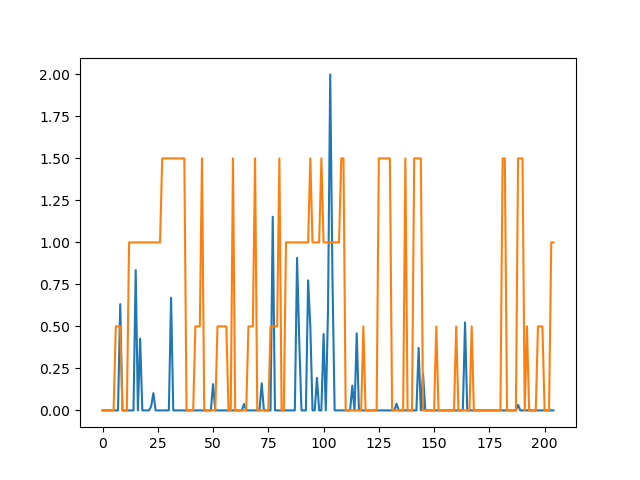

In [210]:
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C_upd = Cupd.loc[unit_to_keep,:]
nb_unit = C_upd.shape[0]

Test2 = C_upd.to_series()
unit = 0
lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
input_arr = lTest2
R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )


if UnitToKeepL:
    SleepScoredTSupd2 = SleepScoredTSupd[:len(dwnsmpl_arrT)]
    dwnsmpl_arrT2 = 2*dwnsmpl_arrT/max(dwnsmpl_arrT)
    dwnsmpl_arrT2 = dwnsmpl_arrT2[0:len(SleepScoredTSupd)]

    plt.close()
    plt.plot(dwnsmpl_arrT2)
    plt.plot(SleepScoredTSupd2)
    plt.show()
else:
    plt.close()



In [211]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    Activity_state["Unit"][unit] = UnitToKeepL[unit] #added by AB
    for time_stamp in range(len(dwnsmpl_arrT2)):
        if(SleepScoredTSupd2[time_stamp] == 1):
            Activity_state["REM"][unit] = Activity_state["REM"][unit] + dwnsmpl_arrT[time_stamp]    
        elif(SleepScoredTSupd2[time_stamp] == 0.5):
            Activity_state["N2"][unit] = Activity_state["N2"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 1.5):
            Activity_state["Wake"][unit] = Activity_state["Wake"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 0):
            Activity_state["NREM"][unit] = Activity_state["NREM"][unit] + dwnsmpl_arrT[time_stamp]     

In [212]:
data = {
    'Wake' : np.zeros(2),
    'NREM' : np.zeros(2),
    'N2' : np.zeros(2),
    'REM' : np.zeros(2),
}
Activity_state_time = pd.DataFrame(data, columns=['Wake', 'NREM', 'N2', 'REM'])

for time_stamp in range(len(dwnsmpl_arrT)):
    if(SleepScoredTSupd2[time_stamp] == 1):
        Activity_state_time["REM"][0] = Activity_state_time["REM"][0] + 1   
    elif(SleepScoredTSupd2[time_stamp] == 0.5):
        Activity_state_time["N2"][0] = Activity_state_time["N2"][0] + 1
    elif(SleepScoredTSupd2[time_stamp] == 1.5):
        Activity_state_time["Wake"][0] = Activity_state_time["Wake"][0] + 1    
    elif(SleepScoredTSupd2[time_stamp] == 0):
        Activity_state_time["NREM"][0] = Activity_state_time["NREM"][0] + 1     

Activity_state_time["REM"][1] = Activity_state_time["REM"][0]/len(dwnsmpl_arrT)
Activity_state_time["N2"][1] = Activity_state_time["N2"][0]/len(dwnsmpl_arrT)
Activity_state_time["Wake"][1] = Activity_state_time["Wake"][0]/len(dwnsmpl_arrT)
Activity_state_time["NREM"][1] = Activity_state_time["NREM"][0]/len(dwnsmpl_arrT)
Activity_state_time.index = ['absolu', 'percentage']

# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_n = Activity_state.copy()
row_sums = Activity_state_n.sum(axis=1)
Activity_state_n = Activity_state_n.div(row_sums, axis=0) #Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight = round(Activity_state_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight.apply(np.sum, axis=0)/nb_unit

N2       7.333333
NREM     2.333333
REM     20.000000
Unit     0.000000
Wake     7.666667
dtype: float64

In [213]:
#filenameUnit = folder_sessionMini / f'UnitToKeep.xlsx'
#unitname = pd.read_excel(filenameUnit)
RelativeWeight['Unit'] = UnitToKeepL

filenameOut = folder_Minis / f'IntensityNormalisedVigilanceStatesAB.xlsx' #f'SpikeVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight.to_excel(writer)
writer.close()

In [214]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state_frame = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    for time_stamp in range(len(dwnsmpl_arrT)):
        if((SleepScoredTSupd2[time_stamp] == 1) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["REM"][unit] = Activity_state_frame["REM"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 0.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["N2"][unit] = Activity_state_frame["N2"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 1.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["Wake"][unit] = Activity_state_frame["Wake"][unit] + 1     
        elif((SleepScoredTSupd2[time_stamp] == 0) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["NREM"][unit] = Activity_state_frame["NREM"][unit] + 1     

# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_frame_n = Activity_state_frame.copy()
Activity_state_frame_n.apply(np.sum, axis=1)
row_sums_frame = Activity_state_frame_n.sum(axis=1)
Activity_state_frame_n = Activity_state_frame_n.div(row_sums_frame, axis=0) # Activity_state_frame_n / row_sums_frame[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight_frame = round(Activity_state_frame_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight_frame.apply(np.sum, axis=0)/nb_unit

N2       72.333333
NREM     69.666667
REM     150.333333
Unit      0.000000
Wake    154.000000
dtype: float64

In [215]:
filenameOut = folder_Minis / f'NumFrameNormalisedVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight_frame.to_excel(writer)
writer.close()

In [216]:
Activity_state_time

,Wake,NREM,N2,REM
absolu,35.000000,104.000000,26.000000,40.000000
percentage,0.170732,0.507317,0.126829,0.195122
